# Predicting California Housing Prices using KNN

This project involves building a machine learning pipeline using the K-Nearest Neighbors (KNN) algorithm to predict median house prices in California. The workflow includes data preprocessing, model training with cross-validation, hyperparameter tuning, evaluation, and model persistence.



In [1]:
import pandas as pd
import pickle
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error


In [15]:
#loading the california dataset
X,y = fetch_california_housing(return_X_y=True, as_frame=True)
X


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


First 5 rows of the dataset:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Summary statistics:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


Missing values per column:


MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

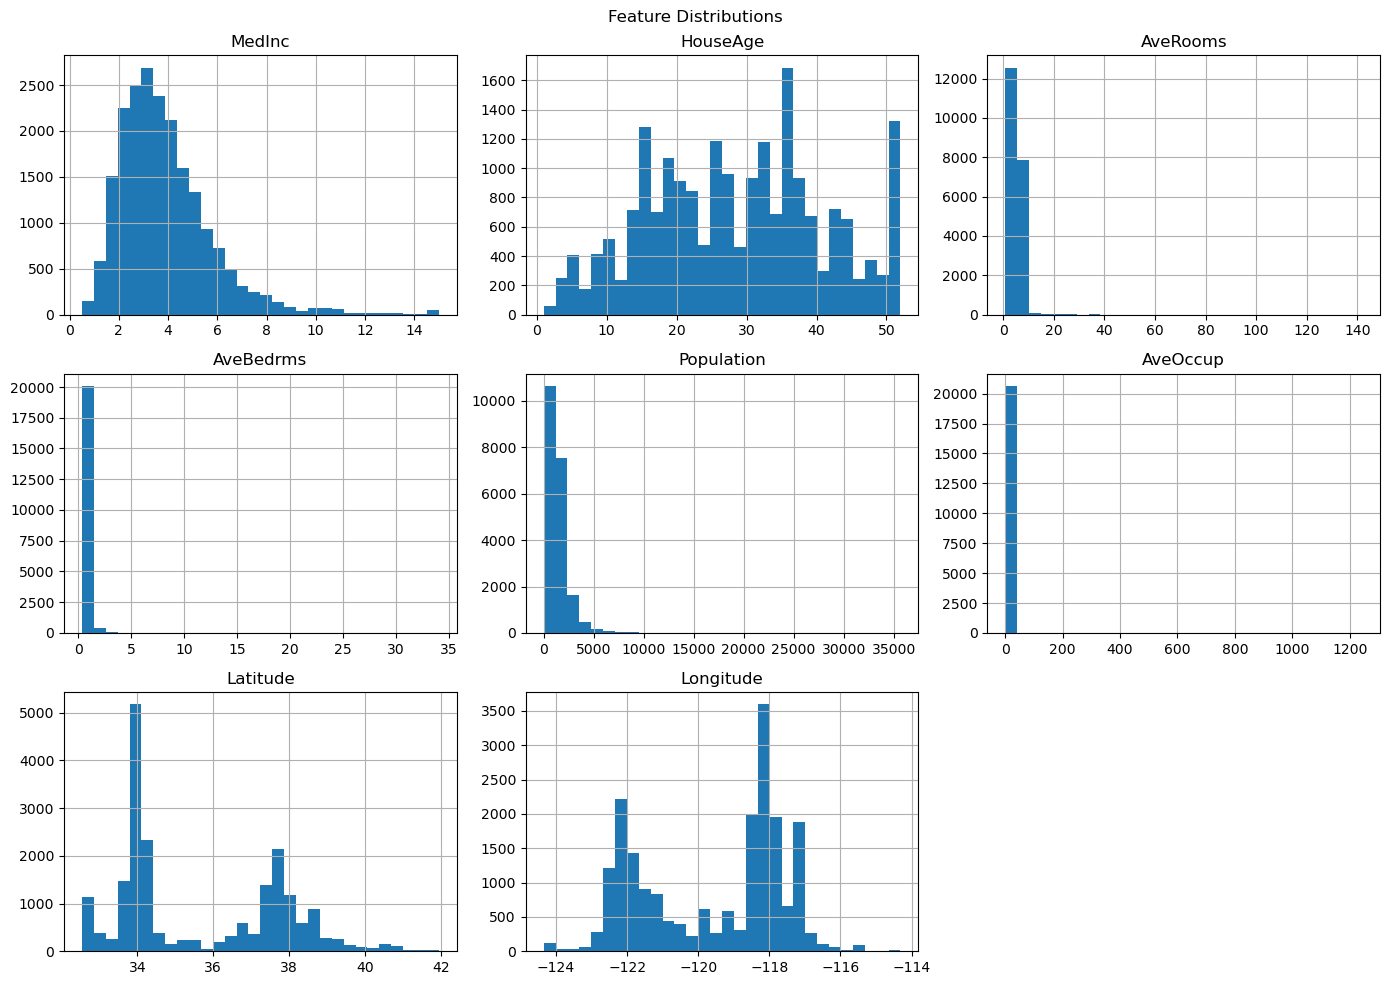

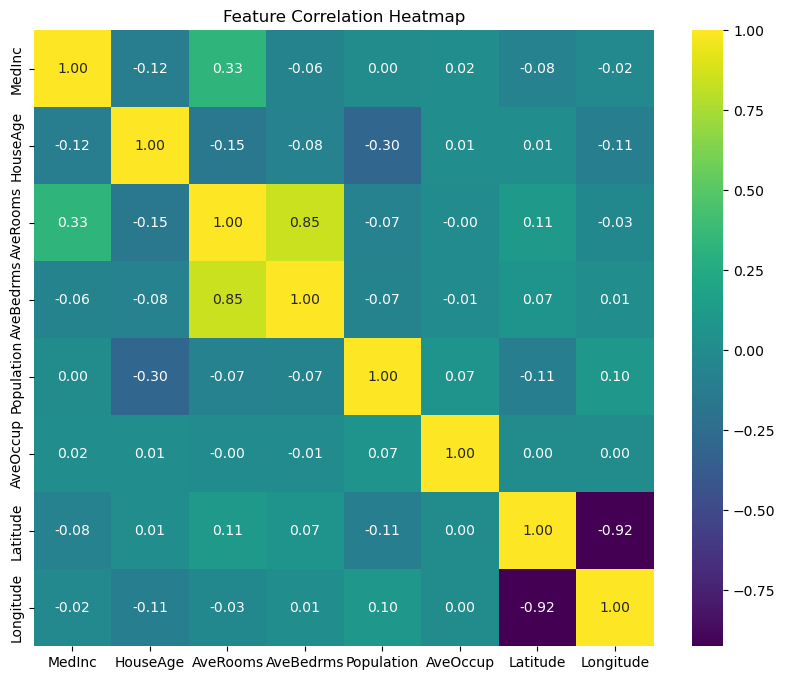

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Quick view of the dataset
print("First 5 rows of the dataset:")
display(X.head())

# Summary stats
print("Summary statistics:")
display(X.describe())

# Check for missing values
print("Missing values per column:")
display(X.isnull().sum())

# Plot distributions of all features
X.hist(bins=30, figsize=(14, 10))
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [4]:
# spliting the data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
# Preprocessing pipline
numeric_features = X.columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # filling missing values with mean
    ('scaler', StandardScaler())  # scaling features to mean=0, std=1
])


In [6]:
#combining preprocessing using column transformers
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])


In [7]:
#Building the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor())
])


In [8]:
#Setting Up Hyperparameter Grid for Tuning
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],  # how neighbors are weighted
    'knn__p': [1, 2]  # 1=Manhattan, 2=Euclidean
}


In [9]:
#Running Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # evaluation metric
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object'))])),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 9], 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='r2', verbose=1)

In [10]:
# Evaluating the best model
best_model = grid_search.best_estimator_  # best pipeline from grid search
y_pred = best_model.predict(X_test)  # predict on test set

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

import numpy as np
rmse = np.sqrt(mean_squared_error(y_test, y_pred))



In [11]:
print("\n Final Evaluation on Test Data")
print("-" * 40)
print(f" Best Parameters: {grid_search.best_params_}")
print(f" Best CV R² Score: {grid_search.best_score_:.4f}")
print(f" Test R² Score: {r2:.4f}")
print(f" Test MSE: {mse:.4f}")
print(f" Test RMSE: {rmse:.4f}")



 Final Evaluation on Test Data
----------------------------------------
 Best Parameters: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}
 Best CV R² Score: 0.7313
 Test R² Score: 0.7221
 Test MSE: 0.3642
 Test RMSE: 0.6034


In [12]:
#saving the trained pipeline
with open('california_knn_pipeline.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(" Final pipeline saved to 'california_knn_pipeline.pkl'")


 Final pipeline saved to 'california_knn_pipeline.pkl'


In [13]:
# After training and evaluation
import pickle

with open('california_knn_pipeline.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Model saved as 'california_knn_pipeline.pkl'")


Model saved as 'california_knn_pipeline.pkl'
